# <span style='color:blue'> Stacking Generalization of ML classifiers</span>

The present `Jupyter Notebook` contains the creation and evaluation of some models by stacking generalization from the best performing classifiers.

## Import Essentials

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

import matplotlib.transforms as mtransforms

import pickle

In [2]:
# Import functions from customized modules
from pathlib import Path
import sys

PROJECT_DIR = list(Path("..").absolute().parents)[0]
sys.path.append(str(PROJECT_DIR) + '/Scripts/')

from preprocessing import feature_filt
from classification import model_eval, create_model

## File names and colors

In [3]:
# File names and sheet names
descriptors_file = './Data/BTZs_full_descriptors_final.xlsx'
data_matrix = 'general_data_matrix'
desc = 'descriptors'

# Define files for retrieving info from the respective hyperparameter optimization files
hyperparam_data = ['./Results/result_rd_rf.csv', 
                   './Results/result_rd_svm.csv',
                   './Results/result_rd_knn.csv',
                   './Results/result_rd_ada.csv']


statistics_input = './Results/Statistics_ML_models.csv'
statistics_output = './Results/Full_statistics_ML_models.csv'

In [4]:
colors1 = ['#ca0020', '#f4a582', '#92c5de', '#0571b0']
colors2 = ['#d7191c', '#fdae61', '#ffffbf', '#abd9e9', '#2c7bb6']

## Load and prepare data  

Stacking generalization was exclusively applied to the best performing models (i.e. descriptor-based classifiers with training from seed 31 or 57)

In [5]:
# Load data set with SMILES
BTZs = pd.read_excel(descriptors_file, sheet_name=data_matrix)

# Load set of descriptors 
desc = pd.read_excel(descriptors_file, sheet_name=desc)

In [6]:
# Create X data sets from descriptors and molecular fingerprints
Xdesc = desc.iloc[:, 1:] 
print('X descriptors shape {}'.format(Xdesc.shape))

X descriptors shape (96, 227)


In [7]:
y = BTZs.Class

print('y shape {}'.format(y.shape))

y shape (96,)


## Prepare base estimators

The four selected algorithms used are instantiated using the best group of hyperparameters found by randomized search (SciKit-Learn). 

In [8]:
# We start with the selected random seeds
seed = [57, 31]

In [9]:
# Create an empty dictionary for storing hyperparameter information for all the algorithms
hyperparam = {}
# Iterate to get information
for filename in hyperparam_data:
    d = pd.read_csv(filename, index_col=0)
    hyperparam[filename.split('_')[2].split('.')[0]] = d.loc[seed]
    

In [10]:
# Initialize selected models
models = {}
for alg in hyperparam.keys():
    for i in seed:
        model = create_model(alg, hyperparam[alg], i)
        models[alg + str(i)] = model

In [11]:
# Mark the models for ease of practice
m1 = models['rf57']
m2 = models['knn57']
m3 = models['svm57']
m4 = models['ada57']

m5 = models['rf31']
m6 = models['knn31']
m7 = models['svm31']
m8 = models['ada31']


## Create models by stacking generalization

The models are created using sklearn tools.

In [12]:
# Define training and test sets
X_train57, X_test57, y_train57, y_test57 = feature_filt(Xdesc, y, 0.25, 57)
X_train31, X_test31, y_train31, y_test31 = feature_filt(Xdesc, y, 0.25, 31)

In [13]:
# Create the models
base_models57 = [('rf', m1), ('knn', m2), ('svm', m3), ('ada', m4)]
base_models31 = [('rf', m5), ('knn', m6), ('svm', m7), ('ada', m8)]

meta_model = LogisticRegression(random_state=21)

stacking_models57 = StackingClassifier(estimators=base_models57, final_estimator=meta_model, cv=5)

stacking_models31 = StackingClassifier(estimators=base_models31, final_estimator=meta_model, cv=5)


## Evaluate and score models

The evaluation and scoring are carried out following the same directions as before (Notebook 3).

In [14]:
# Assess statistical validity of both models
stats_s57 = model_eval(stacking_models57, X_train57, X_test57, y_train57, y_test57)
stats_s31 = model_eval(stacking_models31, X_train31, X_test31, y_train31, y_test31) 

In [15]:
# Load dataframe with statistics of the whole set of models
whole_statistics = pd.read_csv(statistics_input)

In [16]:
# Same scoring function as before

# Scheme to try:
# If value > 0.8 --> 2 points
# If value only > 0.75 --> 1 point
# If value < 0.65 --> - 1 point

def score(x):
    if x >= 0.8:
        s = 2
    elif (x >= 0.75) & (x < 0.8):
        s = 1
    elif x < 0.65:
        s = -1
    else:
        s = 0
        
    return s

In [17]:
# Define labels and models
stacked_labels = ['M37', 'M38']
stacked_stats = [stats_s57, stats_s31]

# Score the newly generated stacked models
for lab, stats, x in zip(stacked_labels, stacked_stats, seed):
    scores = []
    for i, j in enumerate(stats):
        if i in [0, 1, 2, 4, 5, 6]:
            s = score(j)
        elif i in [3, 7]:
            s = score((j + 1) / 2)
        else:
            s = 0
        scores.append(s)
    whole_statistics.loc[len(whole_statistics)] = [lab] + stats + ['stack', x, 'desc', sum(scores)]


In [18]:
whole_statistics

,Model,AUC_cv,BA_cv,f1_cv,MCC_cv,AUC_t,BA_t,f1_t,MCC_t,algorithm,seed,data,score
0,M1,0.832474,0.752639,0.783236,0.525386,0.907143,0.842857,0.818182,0.676123,rf,57,desc,13
1,M2,0.855529,0.812996,0.823209,0.638320,0.850000,0.878571,0.857143,0.749159,knn,57,desc,16
2,M3,0.816647,0.752758,0.802573,0.535479,0.921429,0.785714,0.769231,0.597614,svm,57,desc,11
3,M4,0.832407,0.778591,0.804207,0.578503,0.907143,0.842857,0.818182,0.676123,ada,57,desc,14
4,M5,0.874783,0.822143,0.838960,0.657314,0.843750,0.833333,0.846154,0.676123,rf,31,desc,16
5,M6,0.866165,0.811786,0.809618,0.633330,0.819444,0.708333,0.695652,0.418121,knn,31,desc,10
6,M7,0.874447,0.791488,0.803370,0.593979,0.819444,0.791667,0.782609,0.585369,svm,31,desc,11
7,M8,0.865663,0.802679,0.819413,0.617642,0.826389,0.791667,0.814815,0.602464,ada,31,desc,15
8,M9,0.759306,0.707083,0.750115,0.425710,0.900000,0.788889,0.736842,0.567367,rf,86,desc,6
9,M10,0.848866,0.792778,0.825459,0.594602,0.962963,0.844444,0.800000,0.669342,knn,86,desc,13


In [19]:
# Comparing models based on mean value for CV and external validation
red1 = pd.concat((whole_statistics.iloc[:, 1:4], (whole_statistics.iloc[:, 4] + 1) / 2), axis=1)
red1.columns = red1.columns.tolist()[:3] + ['nMCC_cv']
red2 = pd.concat((whole_statistics.iloc[:, 5:8], (whole_statistics.iloc[:, 8] + 1) / 2), axis=1)
red2.columns = red2.columns.tolist()[:3] + ['nMCC_t']


In [20]:
best_mean = pd.DataFrame(columns=['mean'])
best_mean['mean'] = pd.concat((red1, red2), axis=1).mean(axis=1)
best_mean = pd.concat((whole_statistics.iloc[:, 0], best_mean, whole_statistics.iloc[:, 9:]), axis=1)
best_mean.sort_values(by='mean', inplace=True, ascending=False)
best_mean

,Model,mean,algorithm,seed,data,score
1,M2,0.846398,knn,57,desc,16
36,M37,0.846058,stack,57,desc,15
4,M5,0.840730,rf,31,desc,16
9,M10,0.838310,knn,86,desc,13
37,M38,0.834410,stack,31,desc,16
3,M4,0.826338,ada,57,desc,14
0,M1,0.817161,rf,57,desc,13
7,M8,0.816335,ada,31,desc,15
14,M15,0.814619,svm,57,morgan,14
6,M7,0.806587,svm,31,desc,11


In [21]:
new_whole_statistics = pd.concat((whole_statistics.iloc[:, 0], red1, red2, 
                                  whole_statistics.iloc[:, 9:]), axis=1)
new_whole_statistics

,Model,AUC_cv,BA_cv,f1_cv,nMCC_cv,AUC_t,BA_t,f1_t,nMCC_t,algorithm,seed,data,score
0,M1,0.832474,0.752639,0.783236,0.762693,0.907143,0.842857,0.818182,0.838062,rf,57,desc,13
1,M2,0.855529,0.812996,0.823209,0.819160,0.850000,0.878571,0.857143,0.874579,knn,57,desc,16
2,M3,0.816647,0.752758,0.802573,0.767739,0.921429,0.785714,0.769231,0.798807,svm,57,desc,11
3,M4,0.832407,0.778591,0.804207,0.789251,0.907143,0.842857,0.818182,0.838062,ada,57,desc,14
4,M5,0.874783,0.822143,0.838960,0.828657,0.843750,0.833333,0.846154,0.838062,rf,31,desc,16
5,M6,0.866165,0.811786,0.809618,0.816665,0.819444,0.708333,0.695652,0.709061,knn,31,desc,10
6,M7,0.874447,0.791488,0.803370,0.796990,0.819444,0.791667,0.782609,0.792685,svm,31,desc,11
7,M8,0.865663,0.802679,0.819413,0.808821,0.826389,0.791667,0.814815,0.801232,ada,31,desc,15
8,M9,0.759306,0.707083,0.750115,0.712855,0.900000,0.788889,0.736842,0.783683,rf,86,desc,6
9,M10,0.848866,0.792778,0.825459,0.797301,0.962963,0.844444,0.800000,0.834671,knn,86,desc,13


In [22]:
# Export final matrix with all the statistical results
new_whole_statistics.to_csv(statistics_output)

<Figure size 432x288 with 0 Axes>

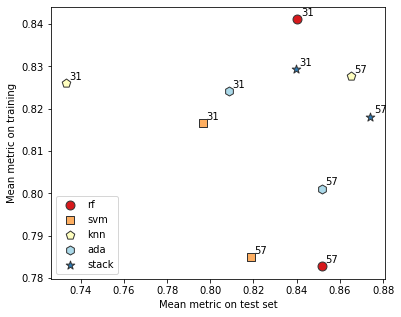

In [23]:
# Define data to plot
data = new_whole_statistics[(new_whole_statistics.data == 'desc') & (new_whole_statistics.seed != 86)]
red1_plot = red1[(new_whole_statistics.data == 'desc') & (new_whole_statistics.seed != 86)]
red2_plot = red2[(new_whole_statistics.data == 'desc') & (new_whole_statistics.seed != 86)]

# Define labels and markers
labels1 = ['rf', 'svm', 'knn', 'ada', 'stack']
markers1 = ['o', 's', 'p', 'h', '*']


plt.figure()
fig, ax = plt.subplots(figsize=(6, 5))
# Add scatter plot for each algorithm
for lab, c, mark in zip(labels1, colors2, markers1):
    ax.scatter(red2_plot[data.algorithm == lab].mean(axis=1), red1_plot[data.algorithm == lab].mean(axis=1),
               c=c, marker=mark, s=80, edgecolors=[0.2, 0.2, 0.2], label=lab)

# Define offset distance    
trans_offset = mtransforms.offset_copy(ax.transData, fig=fig,
                                       x=0.05, y=0.05, units='inches')
# Add text labels
for i in range(len(red2_plot)):
    ax.text(red2_plot.mean(axis=1).values[i], red1_plot.mean(axis=1).values[i], 
            str(data.seed.values[i]), transform=trans_offset)

# Edit axes
ax.set_xlabel('Mean metric on test set')
ax.set_ylabel('Mean metric on training')

# Add legend
plt.legend(loc='lower left')

plt.show()

## Further analysis of selected best models (M2, M5, M37, M38)

In [24]:
# Define a subset of data from the best models
stats_for_plot = new_whole_statistics[new_whole_statistics.Model.isin(['M2', 'M5', 'M37', 'M38'])].iloc[:, :9]
stats_for_plot

,Model,AUC_cv,BA_cv,f1_cv,nMCC_cv,AUC_t,BA_t,f1_t,nMCC_t
1,M2,0.855529,0.812996,0.823209,0.819160,0.850000,0.878571,0.857143,0.874579
4,M5,0.874783,0.822143,0.838960,0.828657,0.843750,0.833333,0.846154,0.838062
36,M37,0.857672,0.794563,0.816740,0.803478,0.885714,0.878571,0.857143,0.874579
37,M38,0.884099,0.805536,0.817073,0.810745,0.840278,0.833333,0.846154,0.838062


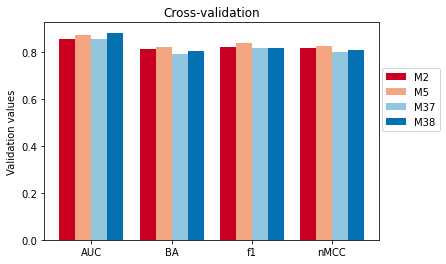

In [25]:
# Define labels and groups for plotting
labels2 = ['AUC', 'BA', 'f1', 'nMCC']

barWidth = 0.2  # the width of the bars

x1 = np.arange(len(labels2))  # the label locations
x2 = [i + barWidth for i in x1]
x3 = [i + barWidth for i in x2]
x4 = [i + barWidth for i in x3]

# Create bar plot for each metrics
fig, ax = plt.subplots()
# rects1 = ax.bar(x1, stats_for_plot.iloc[0,1:5], color='lightslategray', width=barWidth, label=stats_for_plot.Model.iloc[0])
# rects2 = ax.bar(x2, stats_for_plot.iloc[1,1:5], color='mediumseagreen', width=barWidth, label=stats_for_plot.Model.iloc[1])
# rects3 = ax.bar(x3, stats_for_plot.iloc[2,1:5], color='limegreen', width=barWidth, label=stats_for_plot.Model.iloc[2])
# rects4 = ax.bar(x4, stats_for_plot.iloc[3,1:5], color='palegreen', width=barWidth, label=stats_for_plot.Model.iloc[3])

for x, i, c in zip([x1, x2, x3, x4], range(len(labels2)), colors1):
    ax.bar(x, stats_for_plot.iloc[i, 1:5], color=c, width=barWidth, label=stats_for_plot.Model.iloc[i])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Validation values')
ax.set_title('Cross-validation')
ax.set_xticks([(i + j) / 2 for i, j in zip(x2, x3)])
ax.set_xticklabels(labels2)

# Add legend
ax.legend(loc=(1.01, 0.5), ncol=1)

plt.show()

<Figure size 432x288 with 0 Axes>

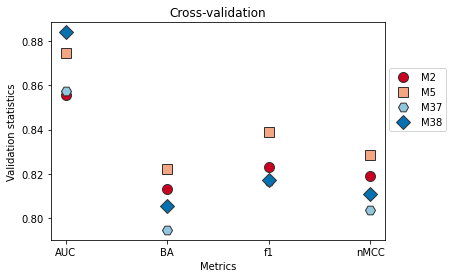

In [26]:
labels2 = ['AUC', 'BA', 'f1', 'nMCC']

x1 = np.arange(len(labels2))  # the label locations

plt.figure()
fig, ax = plt.subplots()
# Plot metrics for each classifier
for i, c, m in zip(range(len(labels2)), colors1, ['o', 's', 'H', 'D']):
    ax.plot(x1, stats_for_plot.iloc[i, 1:5], linestyle='', color=c, marker=m, 
            markersize=10, markeredgecolor=[0.2, 0.2, 0.2], label=stats_for_plot.Model.iloc[i])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Validation statistics')
ax.set_xlabel('Metrics')
ax.set_title('Cross-validation')
ax.set_xticks(x1)
ax.set_xticklabels(labels2)

# Add legend
ax.legend(loc=(1.01, 0.5), ncol=1)

plt.show()

<Figure size 432x288 with 0 Axes>

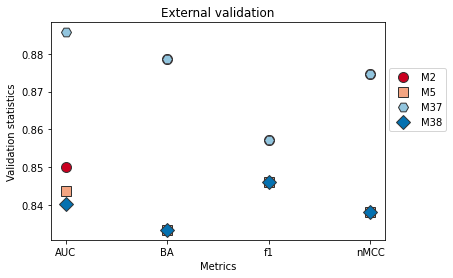

In [27]:
# Repeat plot for test set
plt.figure()
fig, ax = plt.subplots()
# Plot metrics for each classifier
for i, c, m in zip(range(len(labels2)), colors1, ['o', 's', 'H', 'D']):
    ax.plot(x1, stats_for_plot.iloc[i, 5:], linestyle='', color=c, marker=m, 
            markersize=10, markeredgecolor=[0.2, 0.2, 0.2], label=stats_for_plot.Model.iloc[i])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Validation statistics')
ax.set_xlabel('Metrics')
ax.set_title('External validation')
ax.set_xticks(x1)
ax.set_xticklabels(labels2)

# Add legend
ax.legend(loc=(1.01, 0.5), ncol=1)

plt.show()

In [28]:
# Finally export the models:

m5.fit(X_train31, y_train31)
with open('./Results/M5.pkl', 'wb') as file:
    pickle.dump(m5, file)
    
m2.fit(X_train57, y_train57)
with open('./Results/M2.pkl', 'wb') as file:
    pickle.dump(m2, file)

stacking_models31.fit(X_train31, y_train31)
with open('./Results/M38.pkl', 'wb') as file:
    pickle.dump(stacking_models31, file)

stacking_models57.fit(X_train57, y_train57)
with open('./Results/M37.pkl', 'wb') as file:
    pickle.dump(stacking_models57, file)
